In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.techindicators import TechIndicators
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

%matplotlib inline

# Implementation:

1. Import and transform JM's data based on prev example data's format（按之前的例子导入、清洗和转换焦煤和焦炭的数据格式）: 
2. Build a feature based on JM&J's relative strength difference（计算焦煤和焦炭相对差，作为重要特征因子）
3. Train and test and validate data (训练、测试与验证)
4. Pick the best model parameter sets to backtest（挑选并结合最佳机器学习模型，进行回测）

# Import Futures Data（导入焦煤焦炭数据）

In [51]:
location = "/Users/miaoyuesun/Code_Workspace/brad_public_workspace_mac/data/"
j = "j9000.csv"
jm = "jm000.csv"

j_df = pd.read_csv(location+j, engine="python", header=None)
jm_df = pd.read_csv(location+jm, engine='python', header=None)

j_df.columns = ['date', 'open', 'high', 'low', 'close', 'volume', 'holdings']
jm_df.columns = ['date', 'open', 'high', 'low', 'close', 'volume', 'holdings']

jm_df_cols = jm_df[['date', 'open', 'high', 'low', 'close', 'volume']]
j_df_cols = j_df[['date', 'open', 'high', 'low', 'close', 'volume']]

jm_df_cols['date'] = pd.to_datetime(jm_df_cols['date'])
j_df_cols['date'] = pd.to_datetime(j_df_cols['date'])

jm_df_cols.index = jm_df_cols['date']
j_df_cols.index = j_df_cols['date']

jm_df_cols = jm_df_cols.resample('D').last()
j_df_cols = j_df_cols.resample('D').last()

del jm_df_cols['date']
del j_df_cols['date']

jm_df_cols.dropna(inplace=True)
j_df_cols.dropna(inplace=True)

/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [55]:
jm_df_cols.reset_index(inplace=True)
j_df_cols.reset_index(inplace=True)

In [56]:
jm_df_cols

,date,open,high,low,close,volume
0,2013-03-22,1270.0,1282.0,1263.0,1268.0,191864.0
1,2013-03-25,1263.0,1265.0,1256.0,1259.0,162280.0
2,2013-03-26,1269.0,1277.0,1268.0,1273.0,214850.0
3,2013-03-27,1265.0,1269.0,1263.0,1263.0,76340.0
4,2013-03-28,1271.0,1272.0,1250.0,1261.0,262676.0
5,2013-03-29,1252.0,1257.0,1240.0,1242.0,189814.0
6,2013-04-01,1210.0,1211.0,1204.0,1204.0,97538.0
7,2013-04-02,1219.0,1232.0,1209.0,1230.0,351140.0
8,2013-04-03,1219.0,1225.0,1216.0,1218.0,110006.0
9,2013-04-08,1222.0,1225.0,1218.0,1222.0,105480.0


# Calculate RSD（计算相对差）

In [62]:
jm_close = jm_df_cols[['date','close']]
jm_close.columns = ['date','jm_close']
j_close = j_df_cols[['date','close']]
j_close.columns = ['date','j_close']

In [63]:
j_close.head()

,date,j_close
0,2011-04-15,2250.0
1,2011-04-18,2382.0
2,2011-04-19,2337.0
3,2011-04-20,2344.0
4,2011-04-21,2336.0


In [64]:
jm_close.head()

,date,jm_close
0,2013-03-22,1268.0
1,2013-03-25,1259.0
2,2013-03-26,1273.0
3,2013-03-27,1263.0
4,2013-03-28,1261.0


In [65]:
jm_close.columns

Index(['date', 'jm_close'], dtype='object')

In [68]:
merge_jm_j = jm_close.merge(j_close, on = 'date')

In [70]:
merge_jm_j.head(2)

,date,jm_close,j_close
0,2013-03-22,1268.0,1679.0
1,2013-03-25,1259.0,1683.0


In [71]:
merge_jm_j['jm_pct_chg'] =  merge_jm_j['jm_close'].pct_change()
merge_jm_j['j_pct_chg']  = merge_jm_j['j_close'].pct_change()

In [72]:
# 相对差公式：
merge_jm_j['TM'] = merge_jm_j['jm_pct_chg'] - merge_jm_j['j_pct_chg']

In [78]:
merge_jm_j['TMSUM'] = merge_jm_j['TM'].cumsum()

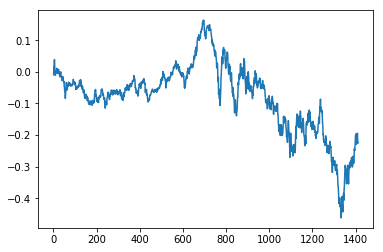

In [80]:
merge_jm_j.TMSUM.plot()

In [39]:
def get_data(symbol):

    # Technical Indicators
    ti = TechIndicators(key='4BTFICZGTPWZRRQS', output_format='pandas')
    sma, _ = ti.get_sma(symbol=symbol, interval='daily')
    wma, _ = ti.get_wma(symbol=symbol, interval='daily')
    ema, _ = ti.get_ema(symbol=symbol, interval='daily')
    macd, _ = ti.get_macd(symbol=symbol, interval='daily')
#     stoch, _ = ti.get_stoch(symbol=symbol, interval='daily')
#     rsi, _ = ti.get_rsi(symbol=symbol, interval='daily')
#     adx, _ = ti.get_adx(symbol=symbol, interval='daily')
#     cci, _ = ti.get_cci(symbol=symbol, interval='daily')
#     aroon, _ = ti.get_aroon(symbol=symbol, interval='daily')
#     bbands, _ = ti.get_bbands(symbol='SPX', interval='daily')
#     ad, _ = ti.get_ad(symbol='SPX', interval='daily')
#     obv, _ = ti.get_obv(symbol='SPX', interval='daily')
#     mom, _ = ti.get_mom(symbol='SPX', interval='daily')
#     willr, _ = ti.get_willr(symbol='SPX', interval='daily')
    tech_ind = pd.concat([sma, ema, macd, stoch], axis=1)

    ts = TimeSeries(key='4BTFICZGTPWZRRQS', output_format='pandas')
    close = ts.get_daily(symbol=symbol, outputsize='full')[0]['4. close']   # compact/full
    direction = (close > close.shift()).astype(int)
    target = direction.shift(-1).fillna(0).astype(int)
    target.name = 'target'

    data = pd.concat([tech_ind, close, target], axis=1)

    return data


def get_indicators(data, n):

    hh = data['2. high'].rolling(n).max()
    ll = data['3. low'].rolling(n).min()
    up, dw = data['4. close'].diff(), -data['4. close'].diff()
    up[up<0], dw[dw<0] = 0, 0
    macd = data['4. close'].ewm(12).mean() - data['4. close'].ewm(26).mean()
    macd_signal = macd.ewm(9).mean()
    tp = (data['2. high'] + data['3. low'] + data['4. close']) / 3
    tp_ma = tp.rolling(n).mean()
    indicators = pd.DataFrame(data=0, index=data.index,
                              columns=['sma', 'ema', 'macd',
#                                        'momentum'
#                                        'sto_k', 'sto_d', 'rsi',
#                                         'lw_r', 'a/d', 'cci'
                                      ])
    indicators['sma'] = data['4. close'].rolling(10).mean()
    indicators['ema'] = data['4. close'].ewm(10).mean()
#     indicators['momentum'] = data['close'] - data['close'].shift(n)
#     indicators['sto_k'] = (data['close'] - ll) / (hh - ll) * 100
#     indicators['sto_d'] = indicators['sto_k'].rolling(n).mean()
#     indicators['rsi'] = 100 - 100 / (1 + up.rolling(14).mean() / dw.rolling(14).mean())
    indicators['macd'] = macd - macd_signal
#     indicators['lw_r'] = (hh - data['close']) / (hh - ll) * 100
#     indicators['a/d'] = (data['high'] - data['close'].shift()) / (data['high'] - data['low'])
#     indicators['cci'] = (tp - tp_ma) / (0.015 * tp.rolling(n).apply(lambda x: np.std(x)))

    return indicators


def rebalance(unbalanced_data):

    # Separate majority and minority classes
    data_minority = unbalanced_data[unbalanced_data.target==0]
    data_majority = unbalanced_data[unbalanced_data.target==1]

    # Upsample minority class
    n_samples = len(data_majority)
    data_minority_upsampled = resample(data_minority, replace=True, n_samples=n_samples, random_state=5)

    # Combine majority class with upsampled minority class
    data_upsampled = pd.concat([data_majority, data_minority_upsampled])

    data_upsampled.sort_index(inplace=True)

    # Display new class counts
    data_upsampled.target.value_counts()

    return data_upsampled


def normalize(x):

    scaler = StandardScaler()
    x_norm = scaler.fit_transform(x.values)
    x_norm = pd.DataFrame(x_norm, index=x.index, columns=x.columns)

    return x_norm


def scores(models, X, y):

    for model in models:
        y_pred = model.predict(X)
        acc = accuracy_score(y, y_pred)
        f1 = f1_score(y, y_pred)
        auc = roc_auc_score(y, y_pred)
        print("Accuracy Score: {0:0.2f} %".format(acc * 100))
        print("F1 Score: {0:0.4f}".format(f1))
        print("Area Under ROC Curve Score: {0:0.4f}".format(auc))

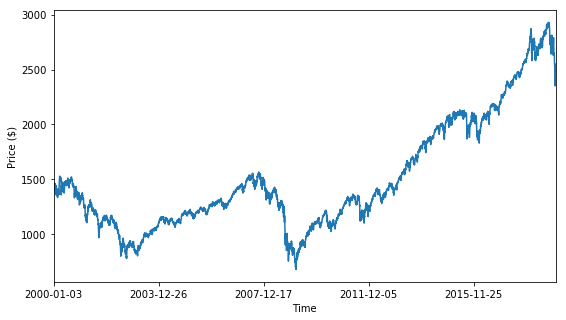

In [40]:
# Part 1:

symbol = 'SPX'  # S&P500
data = get_data(symbol)
data.tail(10)
data.describe()
ax = data['4. close'].plot(figsize=(9, 5))
ax.set_ylabel("Price ($)")
ax.set_xlabel("Time")
plt.show()

In [41]:
# Part 2:

data_train = data['2011-01-01':'2017-01-01']
data_train = rebalance(data_train)
y = data_train.target
X = data_train.drop('target', axis=1)
X = normalize(X)
data_val = data['2017-01-01':]
y_val = data_val.target
X_val = data_val.drop('target', axis=1)
X_val = normalize(X_val)

In [107]:
# Part 3"
# Machine Learning

# Train test split
import sklearn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/6)

models = [GaussianNB(priors=None),
          SVC(random_state=5),
          RandomForestClassifier(random_state=5),
          MLPClassifier(random_state=5)]

for model in models:
    model.fit(X_train, y_train)

scores(models, X_test, y_test)

Accuracy Score: 50.92 %
F1 Score: 0.3383
Area Under ROC Curve Score: 0.5046
Accuracy Score: 52.40 %
F1 Score: 0.4163
Area Under ROC Curve Score: 0.5208
Accuracy Score: 69.37 %
F1 Score: 0.6556
Area Under ROC Curve Score: 0.6919
Accuracy Score: 49.82 %
F1 Score: 0.4426
Area Under ROC Curve Score: 0.4965


In [130]:
# Trying to fix the bracket issue:
grid_data = [
              # Model 1 - GaussianNB(priors=None)'s parameters:
              {'priors': [None]},
    
              # Model 2 - SVC's parameters:
              {'kernel': ['rbf', 'sigmoid'], 'C': [0.1, 1, 10, 100], 'random_state': [5]},
    
              # Model 3 - RandomForestClassifier's parameters:
              {'n_estimators': [10, 50, 100],
               'criterion': ['gini', 'entropy'],
               'max_depth': [None, 10, 50, 100],
               'min_samples_split': [2, 5, 10],
               'random_state': [5]},
    
              # Model 4 - MLPClassifier's parameters:
              {'hidden_layer_sizes': [10, 50, 100],
               'activation': ['identity', 'logistic', 'tanh', 'relu'],
               'solver': ['lbfgs', 'sgd', 'adam'],
               'learning_rate': ['constant', 'invscaling', 'adaptive'],
               'max_iter': [200, 400, 800],
               'random_state': [5]}]

models_grid = list()

In [132]:
for i in range(3):
    print ("Model{}".format(i))
    grid = GridSearchCV(models[i], grid_data[i], scoring='f1').fit(X_train, y_train)
    print(grid.best_params_)
    model = grid.best_estimator_
    models_grid.append(model)
scores(models_grid, X_test, y_test)

Model0
{'priors': None}
Model1
{'random_state': 5, 'C': 100, 'kernel': 'rbf'}
Model2
{'min_samples_split': 5, 'max_depth': None, 'random_state': 5, 'n_estimators': 100, 'criterion': 'entropy'}
Accuracy Score: 50.92 %
F1 Score: 0.3383
Area Under ROC Curve Score: 0.5046
Accuracy Score: 57.93 %
F1 Score: 0.5128
Area Under ROC Curve Score: 0.5770
Accuracy Score: 70.11 %
F1 Score: 0.6747
Area Under ROC Curve Score: 0.6998


In [133]:
# Validation data
scores(models_grid, X_val, y_val)

Accuracy Score: 46.25 %
F1 Score: 0.3524
Area Under ROC Curve Score: 0.4829
Accuracy Score: 50.20 %
F1 Score: 0.5097
Area Under ROC Curve Score: 0.5050
Accuracy Score: 50.59 %
F1 Score: 0.5915
Area Under ROC Curve Score: 0.4905


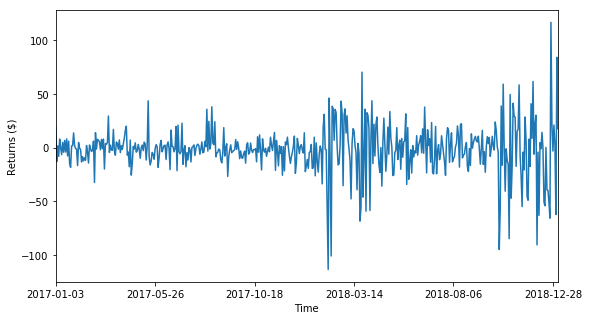

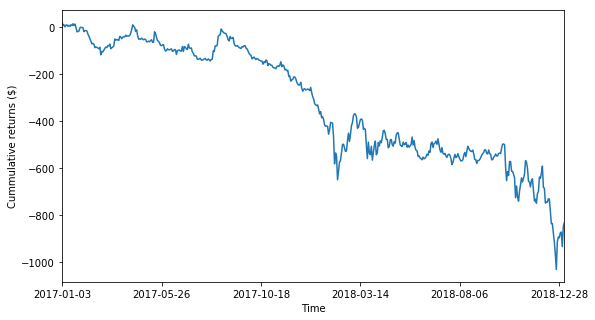

In [135]:
# Trading system
rf_model = models_grid[0]
y_pred = rf_model.predict(X_val)
mask = y_pred.copy()
np.place(mask, y_pred==0, -1)
mask = np.roll(mask, 1)
data_returns = data['4. close'].diff()
data_returns = data_returns[X_val.index]
model_returns = mask * data_returns
model_cum = model_returns.cumsum()
equity = model_returns.sum()
start_close = data["4. close"][X_val.index[0]]
performance = equity / start_close * 100
ax = model_returns.plot(figsize=(9, 5))
ax.set_ylabel("Returns ($)")
ax.set_xlabel("Time")
plt.show()
ax = model_cum.plot(figsize=(9, 5))
ax.set_ylabel("Cummulative returns ($)")
ax.set_xlabel("Time")
plt.show()

In [ ]:
model